# <center>Big Data for Engineers – Exercises</center>
## <center>Spring 2023 – Week 8 – ETH Zurich</center>
## <center>Map Reduce - solutions </center>

This week we will review _MapReduce_—a programming model and distributed system for processing datasets in parallel over large clusters. We will first discuss the two APIs that can be used to write MapReduce jobs. Then, we willimplement a MapReduce job in Python. Finally, we will discuss relevant theory bits behind MapReduce.

## 0. The two APIs for MapReduce

MapReduce provides two different interfaces: the **native MapReduce API** and the **Streaming API**.

The native MapReduce API is equivalent to the one seen in class. To use it, the user has to write two Java classes: one for the Mapper function and one for the Reducer function. Just like in the logical model:

- the Mapper function takes a KeyValue pair and emits zero or more KeyValue pairs;
```js
function map(key, value)
  // Do some work
  emit(someKey, someValue)
```
- and the Reducer function takes a key and a collection of values, and emits zero or more KeyValue pairs (usually one). 
```js
function reduce(key, values[])
  // Do some work
  emit(key, aggregatedValue)
```
  
The Streaming API is usually slower, but allows users to write the Mapper and the Reducer functions in any language — even different languages.
To use the API we need to write two functions, a mapper and a reducer. In this case, however, the programs will directly read the KV pairs as a sequence of lines from standard input and write the resulting KV pairs to standard output.
The streaming API will take care of all the parallelization, the shuffling and everything else required.
Since the operations are done using the standard input and standard output, there are two differences with the logical model:

1. The KV pairs are not independently processed, but read all **sequentially** from standard input.
2. The reducer task does not receive a key with a list of values, but the **ordered list** of KV pairs (one per line). Therefore, the reducer must therefore implement itself the logic for handling a new key. 

## 1. Hands on

In this first part of the exercise session, we will obtain some practical experience with MapReduce. To do so, we will simulate the cluster enviornment by docker.

### 1.1 Start the Hadoop Enviornment

Navigate to the exercise07 folder, bring up docker. It will start several containers for you to simulate the cluster enviornment.

``` bash
docker-compose up
```

Wait until docker finish downloading all the images. This may take several minutes. You should be able to open jupyter notebook using the URL of `localhost:8888` in your browser.

### 1.2 Writing the mapper and the reducer functions

To run a MapReduce job we need of course a mapper function and a reducer. Usually to run natively on Hadoop we need to write our mapper and reducer as classes in Java, but to make the development easier and less cumbersome we are going to use the **Hadoop streaming API**.  
This wonderful API allows the developers to write code in any language and integrate it seamlessly with the MapReduce framework.  
We just need to provide 2 scripts—one for the mapper, one for the reducer—and let them read the KeyValues from `stdin` (the default input stream) and write them to `stdout` (the default output stream). Hadoop will take care of parallelization, the sort step and everything else required.  

To start we will just use the HelloWorld for MapReduce programs, which is WordCount: given a list of files, return for each word the total number of occurrences.  

Copy our sample file to the NameNode container's root directory (make sure you are at the exercise07 directory):

``` bash
docker cp mapper.py namenode:/
docker cp reducer.py namenode:/
```

Loggin to the NameNode. 

``` bash
docker exec -it namenode /bin/bash
```

List the directory to make sure that the python files are correctly copied to the NameNode:

`ls *py`

You can also bring up the terminal by using Docker's graphical user interface. But we recommend that you gradually get used to the command line, because for many tools there is no option of using a GUI. 

Before continuing we need to ensure that the files are actually executable so they can be run by the MapReduce job  
`chmod +x ./reducer.py ./mapper.py`.

Let's take a closer look at the files:

```python
#!/usr/bin/env python3
"""mapper.py"""

import sys
import re

for line in sys.stdin:
    # Set to lowercase, remove punctuations and tokenize
    line = line.lower().strip()
    line = re.sub(r"[^\w\s]", "", line)
    words = line.split()
    for word in words:
        print('%s\t%s' % (word, 1))
```
For the mapper the first line starting with `#!` tells to Hadoop how to run the script (using Python in this case), then for each line in our input (automatically directed to the `sys.stdin` stream by Hadoop) we remove leading and trailing whitespaces, then split the line on each whitespace and 'emit' a key-value pair made up of a word and the unit count one.

```python
#!/usr/bin/env python3
"""reducer.py"""

from operator import itemgetter
import sys

current_word = None
current_count = 0
word = None

for line in sys.stdin:
    line = line.strip()
    word, count = line.split('\t', 1)
    try:
        count = int(count)
    except ValueError:
        continue

    if current_word == word:
        current_count += count
    else:
        if current_word:
            print('%s\t%s' % (current_word, current_count))
        current_count = count
        current_word = word

if current_word == word:
    print('%s\t%s' % (current_word, current_count))

```
For the reducer we receive an ordered list of key-value pairs generated by the mapper and then sorted automatically, so for each line in the input stream, we remove leading and trailing whitespaces, we split the line into the word and the count (always 1 if we used the previous mapper and no combiner), then try to convert the count (by default a string) to a number (and skipping the value in case of failure).  
After that if the word is equal to the previous one (remember the kv pairs are sorted so all the same words will be together) we just increase the count for that word by one, otherwise we print the current word with the associated count and move to the next word.

### 1.3 Test correctness of your program locally

Since a MapReduce job on a cluster usually requires a considerable amount of time, before launching it we want to test our functions locally.  
To do so we can simulate our MapReduce job by inputting the data to the mapper, properly sorting the output of that and feeding it into the reducer, then checking that we get the expected result.  

We can try with   `echo "foo foo quux labs foo bar quux" | ./mapper.py | sort -k1,1 | ./reducer.py`.

### 1.4 Get some data

Download on the cluster some nice books on which we will run our MapReduce job (btw some of these are really nice)
```
wget http://www.gutenberg.org/cache/epub/2500/pg2500.txt 
wget http://www.gutenberg.org/files/1342/1342-0.txt
wget http://www.gutenberg.org/files/84/84-0.txt
wget http://www.gutenberg.org/files/2600/2600-0.txt
wget http://www.gutenberg.org/files/74/74-0.txt
wget http://www.gutenberg.org/files/2591/2591-0.txt
wget http://www.gutenberg.org/files/4300/4300-0.txt
```

and put them on HDFS
```
hadoop fs -mkdir /books
hadoop fs -copyFromLocal ./*.txt /books
```

There will be some encryption trust check popping up with some 'false' messages. Don't worry as this will not influence our experiment. 

You should now be able to find these txt file in HDFS. Open http://localhost:9870/ , Utilities -> Browse the file system.


<img src="files/hdfsbooks.png">


### 1.5 Run the MapReduce job

Finally we are ready to run our MapReduce job:  
```
mapred streaming \
-mapper mapper.py \
-reducer reducer.py \
-file reducer.py \
-file mapper.py \
-input /books/* \
-output /output-folder
```

This command allows us to use the streaming API from Hadoop. We need to pass each file used, the mapper and the reducer and finally the input files and the output folder (__the output folder must be a new non-already-existing folder__).  
We can pass additional configuration parameters, namely we can ask Hadoop to use a certain number of reducers by setting the `numReduceTasks` command-line argument 

```
mapred streaming \
-numReduceTasks 4 \
-mapper mapper.py \
-reducer reducer.py \
-file reducer.py \
-file mapper.py \
-input /books/* \
-output /output-folder2
```


### 1.6 Download and plot the results
The output of the MapReduce process has been stored in your remote cluster. You can now download the result file and plot the frequency of the 30 most common words in the dataset. 

By default, output files have the form `part-XXXX` where `XXXX` is the id of the specific mapper or reducer task.

Refresh the HDFS browser, find the output directory that we specified, click on the output file -> download. You should be direct to a page. Copy the URL. For me, the URL is `http://231212fae531:9864/webhdfs/v1/output-folder/part-00000?op=OPEN&namenoderpcaddress=namenode:9000&offset=0`

<img src="files/hdfsout.png">

<img src="files/hdfsdownload.png">


In [ ]:
# Fill your output URL here
RESULT_FILE_URL = 'XXX'
import urllib.request
urllib.request.urlretrieve (RESULT_FILE_URL, "results.txt")
print ('Done downloading')

Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.poll_control_queue() running at /opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py:227> wait_for=<Future finished result=[<zmq.sugar.fr...x7f3dae5d01a0>, <zmq.sugar.fr...x7f3dae779880>, <zmq.sugar.fr...x7f3ddbf610f0>, <zmq.sugar.fr...x7f3dae6c8a90>, <zmq.sugar.fr...x7f3dae6c8f60>, <zmq.sugar.fr...x7f3dae6c8eb0>, ...]> cb=[_chain_future.<locals>._call_set_state() at /opt/conda/lib/python3.9/asyncio/futures.py:391]>


By reading word counts from results.txt, find the 30 most frequent words in the dataset 

##### Solution

Plotting...


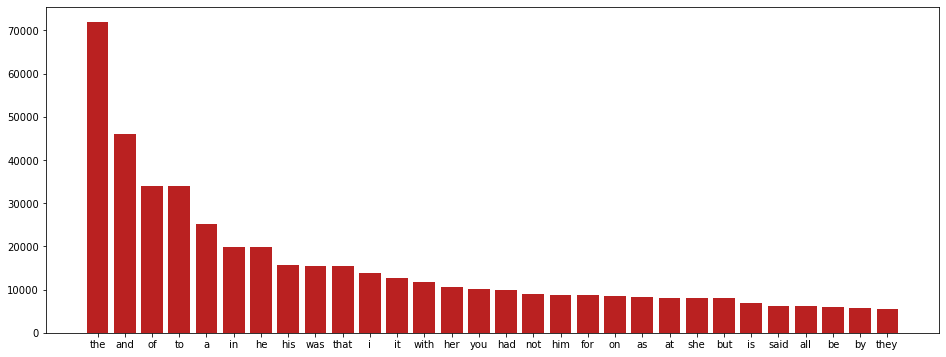

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import operator
print ('Plotting...')
freq = {}

# Read input and sort by frequency. Keep only top 30.
with open('results.txt', 'r') as csvfile:
    for line in csvfile.readlines():
        word, count = line.split('\t')
        freq[word] = int(count)
srt = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)[:30]

# Generate plot
plt.figure(figsize=(16,6))
plt.bar(range(len(srt)), [x[1] for x in srt], align='center', color='#ba2121')
plt.xticks(range(len(srt)), [x[0] for x in srt])
plt.show()

In everything is correct, the 3 most frequent words should be **`the`**, **`of`** and **`and`**.

### 1.7 A Glance to Yarn

YARN is a complex framework that handles resource management on the cluster. You will get to know more about it during the YARN lecture, but for now we will just use it to monitor our MapReduce job live. 

To start monitor the cluster, let's open another terminal connecting to the ResourceManager of the cluster (keep your previous NameNode terminal alive). 

``` bash
docker exec -it resourcemanager /bin/bash
```

Let's see what is the situation with the cluster now.

``` bash
yarn node -list
```

Currently, there should be 0 container running as we have already finished our task. Let's start the task again to see what happens. In the NameNode terminal: 

```
mapred streaming \
-mapper mapper.py \
-reducer reducer.py \
-file reducer.py \
-file mapper.py \
-input /books/* \
-output /output-folder3
```

In the meantime, on the ResourceManager terminal, keep repeating the command (use arrow up on your keyboard to repeat the command). You should be find that the number of container raises at runtime, and return to 0 after the task finished.

Reference screenshot:

<img src="files/yarn.png">

### End of the hands-on part

Shut down docker and delete image if you don't need to revisit this experiment anymore. 

## 2. Understanding MapReduce's execution model

For each of the following statements, state whether it is *true* or *false* and briefly explain why.

1. Each mapper task must generate the same number of key/value pairs as its input had.
2. The TaskTracker is responsible for scheduling mapper and reducer tasks and make sure all nodes are correctly running.
3. Mappers input key/value pairs are sorted by the key.
4. MapReduce splits might not correspond to HDFS block.
5. One single Reducer task is applied to all values associated with the same key.
6. Multiple Reducer tasks can be assigned pairs with the same value.
7. In Hadoop MapReduce, the key-value pairs a Reducer outputs must be of the same type as its input pairs.

**Solution**

1. **False** - for each input pair, the mapper can emit zero, one or several key/value pairs.
2. **False** - the JobTracker is responsible for this.
3. **False** - mapper input is not sorted.
4. **True** - since splits respects logical record boundaries, they might contain data from multiple HDFS blocks.
5. **True** - this is the principle behind partitioning: one Reducer task is responsible for all values associated with a particular key.
6. **True** - values are not relevant in partitioning.
7. **False** - Reducer's input and output pairs might have different types.

## 3. A comprehension task
Conceptually, a map function takes in input a kay-value pair and emits a list of key-values pairs, while a reduce function takes in input a key with an associated list of values and returns a list of values or key-value pairs. Often the type of the final key and value is the same of the type of the intermediate data:

- map     `(k1,v1) -> list(k2,v2)`
- reduce  `(k2,list(v2))-> list(k2, v2)`

Analyze the following Mapper and Reducer functions, written in pseudo-code, and answer the questions below.

```js
function map(key, value)
  emit(key, value);
```

```js
function reduce(key, values[])
  z = 0.0
  for value in values:
    z += value
  emit(key, z / values.length())
```

** Questions **
1. Explain what is the result of running this job on a list of pairs with type ([string], [float]).
2. Could you use this reduce function as combiner as well? Why or why not?
3. If your answer to the previous question was *yes*, does the number of different keys influences the effectiveness of the combiner? If you answer was *no*, can you change (if needed) map and reduce functions in such a way the new reducer the can be used as combiner?

**Solution**

1. This will output a pair `(k1, v1)` for each unique input key, where `k1` is the input key and `v1` is the average of the values associated with `k1`
2. No, because the average operation is not associative.
3. If we allow the final output to contain an additional piece of information (how many samples the average represents), the reducer can be used as combiner, with the values being themselves a pair:

```js
function map(key, value)
  emit(key, (1, value));

function reduce(key, values[])
  n = 0
  z = 0.0
  for value in values:
    n += value[0]
    z += value[0] * value[1]
  emit(key, (n, z / n))
```

## Own Exploration

Imagine you are given a dataset with the temperatures and precipitations around the world for a given day.  
The initial KV pairs consists of `(line number in the file) -> (country,station_id,avg_temperature,mm_of_rain)`.  
You can assume that all station IDs are distinct.   
Write a MapReduce job (using pseudocode as seen in task 3) for each of the following problems, also state whether it is possible to use a combiner to speed up the computation.

1. Find for each country except the UK the maximum avg_temperature  
2. Find for each country the station_id with the maximum avg_temperature  
3. Find for each country the total amount of mm_of_rain but only for countries for which the total is greater than 100mm  
4. Find for each country the total amount of mm_of_rain from stations in which it rained more than 10mm  

**Solution**


1.
```js
function map(key, value)
country,station_id,avg_temperature,mm_of_rain = value
if country != "UK":
    emit(country, avg_temperature)

function reduce(key, values[])
max_temp = value[0]
for value in values:
    max_temp = max(max_temp,value)
emit(key, max_temp)
```
**Combiner use possible**

2.
```js
function map(key, value)
country,station_id,avg_temperature,mm_of_rain = value
emit(country, (station_id,avg_temperature))

function reduce(key, values[])
station_max,max_temp = value[0]
for station_id,temp in values:
    if temp > max_temp:
        max_temp = temp
        station_max = station_id
emit(key, station_max)
```
**Combiner use not possible**

3.
```js
function map(key, value)
country,station_id,avg_temperature,mm_of_rain = value
emit(country, mm_of_rain)

function reduce(key, values[])
tot_rain = 0
for value in values:
    tot_rain += value
if tot_rain > 100:
    emit(key, tot_rain)
```
**Combiner use not possible**

4.
```js
function map(key, value)
country,station_id,avg_temperature,mm_of_rain = value
if mm_of_rain > 10:
    emit(country, mm_of_rain)

function reduce(key, values[])
tot_rain = 0
for value in values:
    tot_rain += value
emit(key, tot_rain)
```
**Combiner use possible**
